In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression,Lasso,Ridge
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap


import warnings
warnings.filterwarnings("ignore")

In [2]:
test = pd.read_csv('test.csv') 
train = pd.read_csv('train.csv') 
sample_submission = pd.read_csv('sample_submission.csv') 

### 1. Check data shape (num of Rows & Columns)

In [3]:
# there are 848835 rows and 6 columns in the train data
train.shape
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   row_id      848835 non-null  int64 
 1   time        848835 non-null  object
 2   x           848835 non-null  int64 
 3   y           848835 non-null  int64 
 4   direction   848835 non-null  object
 5   congestion  848835 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 38.9+ MB


In [4]:
# there are 2340 rows in the test data
test.shape
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   row_id     2340 non-null   int64 
 1   time       2340 non-null   object
 2   x          2340 non-null   int64 
 3   y          2340 non-null   int64 
 4   direction  2340 non-null   object
dtypes: int64(3), object(2)
memory usage: 91.5+ KB


### 2. Check the missing or null values

In [5]:
display(train.isnull().sum())
display(test.isnull().sum())

row_id        0
time          0
x             0
y             0
direction     0
congestion    0
dtype: int64

row_id       0
time         0
x            0
y            0
direction    0
dtype: int64

### 3. Check the duplicate values

In [6]:
display(train.duplicated().sum())
display(test.duplicated().sum())


0

0

### 4. Check the unique values of each column

In [7]:
display(train.nunique())
display(test.nunique())

row_id        848835
time           13059
x                  3
y                  4
direction          8
congestion       101
dtype: int64

row_id       2340
time           36
x               3
y               4
direction       8
dtype: int64

### 5. Check the distribution of each column

<AxesSubplot:xlabel='direction', ylabel='Count'>

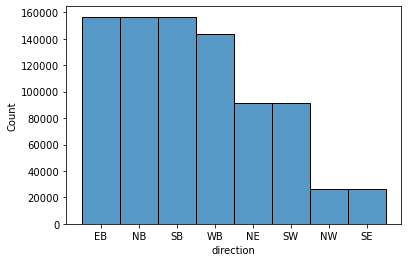

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=train, x="direction", binwidth=2)


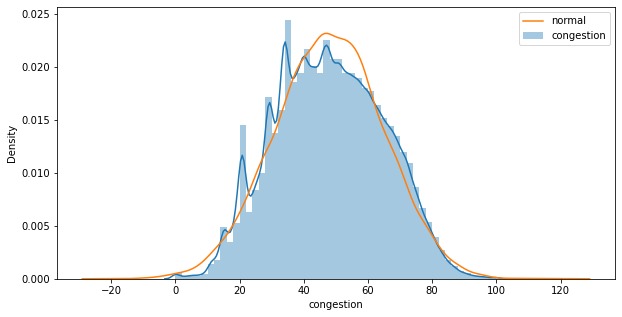

In [9]:
# sns.histplot(data=train, x="congestion", binwidth=5, kde=True)


# fig, ax = plt.subplots(figsize=(20, 10))
# mean, std = train['congestion'].mean(), train['congestion'].std()
# normal_dist = np.random.normal(mean, std, len(train))
# sns.kdeplot(x=normal_dist, ax=ax, label='normal distribution')
# sns.kdeplot(data=train, x='congestion', ax=ax, label='congestion')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.distplot(train['congestion'], label='congestion')
m, s = train['congestion'].mean(), train['congestion'].std()
n = np.random.normal(loc=m, scale=s, size=(100, 100))
ax = sns.distplot(n, hist=False, label='normal')
ax.legend()

### 6. Draw the boxplot of congestion

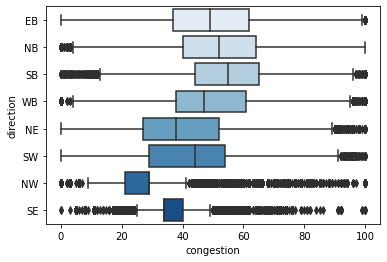

In [10]:
sns.boxplot( y=train["direction"], x=train["congestion"], palette="Blues")
plt.show()

### 7. Visualize the data

## visualize the direction and coordinate

In [11]:
train_process = train.copy()
display(train_process.head())

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [12]:
train_process['x'] = train_process['x'].astype(str)
train_process['y'] = train_process['y'].astype(str)
train_process['xy'] = train_process['x'] + train_process['y']
train_process = train_process.drop(['x', 'y', 'row_id'], axis=1)

train_process = train_process.groupby(['xy', 'direction'])['congestion'].mean().reset_index()

train_process['xy_direction'] = train_process['xy'] + train_process['direction']
train_process = train_process.drop(['xy', 'direction'], axis=1)
train_process = train_process.sort_values(by=['congestion'])
display(train_process)


,congestion,xy_direction
63,19.522322,23SW
45,20.594150,21NE
54,25.542921,22NW
3,26.942492,01EB
46,28.834903,21NW
...,...,...
40,67.082931,20NB
58,67.393751,22WB
4,68.888429,01NB
62,70.617735,23SB


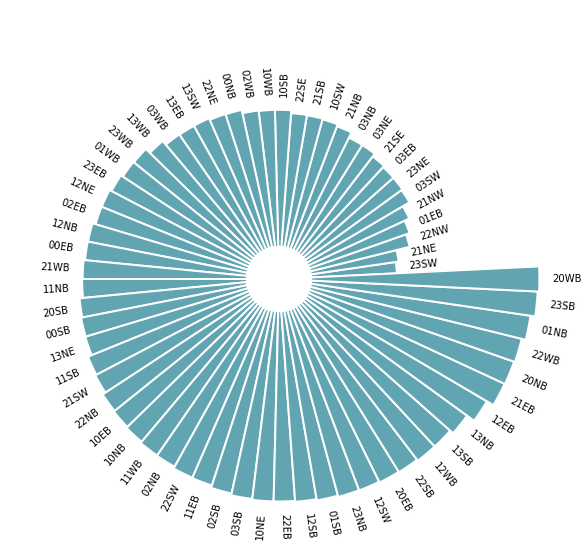

In [13]:
# set figure size
plt.figure(figsize=(20,10))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 100
lowerLimit = 10

# Compute max and min in the dataset
max = train_process['congestion'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * train_process.congestion + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(train_process.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(train_process.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, train_process["xy_direction"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

## Rank by direction

,direction,congestion
3,NW,27.188912
5,SE,34.859637
2,NE,39.971251
6,SW,42.019538
0,EB,49.571171
7,WB,49.842289
1,NB,51.853913
4,SB,53.716332


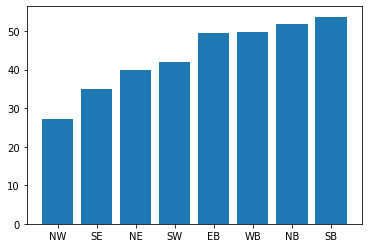

In [14]:
train_process4 = train.copy()
train_process4['x'] = train_process4['x'].astype(str)
train_process4['y'] = train_process4['y'].astype(str)
train_process4['xy'] = train_process4['x'] + train_process4['y']
train_process4 = train_process4.drop(['x', 'y', 'row_id', 'xy'], axis=1)

train_process4 = train_process4.groupby(['direction'])['congestion'].mean().reset_index()
train_process4 = train_process4.sort_values(by=['congestion'])
display(train_process4)





# Make a random dataset:
height = train_process4['congestion']
bars = train_process4['direction']
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()

## Rank by location

,xy,congestion
3,03,38.180080
9,21,40.235872
11,23,45.059525
0,00,45.591214
4,10,46.302065
2,02,48.865495
7,13,48.916852
10,22,49.337038
1,01,49.611571
5,11,52.404319


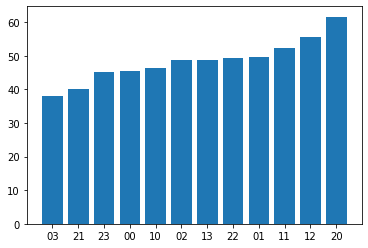

In [15]:
train_process5 = train.copy()
train_process5['x'] = train_process5['x'].astype(str)
train_process5['y'] = train_process5['y'].astype(str)
train_process5['xy'] = train_process5['x'] + train_process5['y']
train_process5 = train_process5.drop(['x', 'y', 'row_id', 'direction'], axis=1)

train_process5 = train_process5.groupby(['xy'])['congestion'].mean().reset_index()
train_process5 = train_process5.sort_values(by=['congestion'])
display(train_process5)





# Make a random dataset:
height = train_process5['congestion']
bars = train_process5['xy']
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()

## visualize the time and location

In [20]:
train_process2 = train.copy()

train_process2['x'] = train_process2['x'].astype(str)
train_process2['y'] = train_process2['y'].astype(str)
train_process2['xy'] = train_process2['x'] + train_process2['y']
train_process2 = train_process2.drop(['x', 'y', 'row_id', 'direction'], axis=1)

train_process2['time'] = pd.to_datetime(train_process2['time'])
train_process2['hour'] = train_process2.time.dt.hour

# create a list of our conditions
conditions = [
    (train_process2['hour'] >= 0)& (train_process2['hour'] < 3),
    (train_process2['hour'] >= 3) & (train_process2['hour'] < 6),
    (train_process2['hour'] >= 6) & (train_process2['hour'] < 9),
    (train_process2['hour'] >= 9)& (train_process2['hour'] < 12),
    (train_process2['hour'] >= 12)& (train_process2['hour'] < 15),
    (train_process2['hour'] >= 15)& (train_process2['hour'] < 18),
    (train_process2['hour'] >= 18)& (train_process2['hour'] < 21),
    (train_process2['hour'] >= 21),
    ]

# create a list of the values we want to assign for each condition
values = ['0_3am', '3am_6am', '6am_9am', '9am_12pm', '12pm_3pm', '3pm_6pm', '6pm_9pm', '9pm_12am']

# create a new column and use np.select to assign values to it using our lists as arguments
train_process2['hour_group'] = np.select(conditions, values)
train_process2 = train_process2.drop(['hour', 'time'], axis=1)
train_process2 = train_process2.groupby(['xy', 'hour_group'])['congestion'].mean().reset_index()

train_process2_sorted = (
    train_process2
    .groupby(["hour_group"])
    .apply(lambda x: x.sort_values(['congestion'], ascending = False))
    .reset_index(drop=True)
)


display(train_process2_sorted)


,xy,hour_group,congestion
0,20,0_3am,55.650061
1,01,0_3am,46.075942
2,11,0_3am,45.894137
3,23,0_3am,44.445930
4,12,0_3am,44.108748
...,...,...,...
91,23,9pm_12am,45.428819
92,10,9pm_12am,44.929943
93,00,9pm_12am,44.477533
94,21,9pm_12am,39.893689


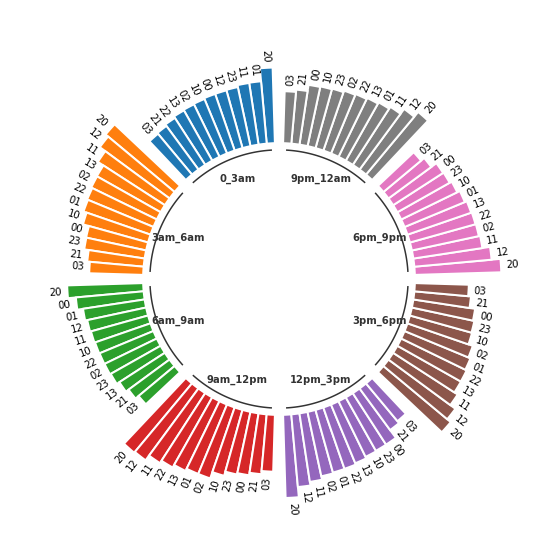

In [21]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 4
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor"
        ) 
        
ANGLES = np.linspace(0, 2 * np.pi, len(train_process2_sorted), endpoint=False)
VALUES = train_process2_sorted['congestion'].values
LABELS = train_process2_sorted["xy"].values

# Determine the width of each bar. 
# The circumference is '2 * pi', so we divide that total width over the number of bars.
WIDTH = 2 * np.pi / len(VALUES)

# Determines where to place the first bar. 
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2



# Grab the group values
GROUP = train_process2_sorted["hour_group"].values

# Add three empty bars to the end of each group
PAD = 1
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

# Obtaining the right indexes is now a little more complicated
offset = 0
IDXS = []
GROUPS_SIZE = [12, 12, 12, 12, 12, 12, 12, 12]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

# Same layout as above
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Use different colors for each group!
GROUPS_SIZE = [12, 12, 12, 12, 12, 12, 12, 12]
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# And finally add the bars. 
# Note again the `ANGLES[IDXS]` to drop some angles that leave the space between bars.
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

offset = 0 
for group, size in zip(['0_3am', '3am_6am', '6am_9am', '9am_12pm', '12pm_3pm', '3pm_6pm', '6pm_9pm', '9pm_12am'], GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -20, group, color="#333333", fontsize=10, 
        fontweight="bold", ha="center", va="center"
    )
    
    offset += size + PAD


## visualize the time and weekday

In [26]:
train_process3 = train.copy()

train_process3['x'] = train_process3['x'].astype(str)
train_process3['y'] = train_process3['y'].astype(str)
train_process3['xy'] = train_process3['x'] + train_process3['y']
train_process3 = train_process3.drop(['x', 'y', 'row_id', 'direction'], axis=1)

train_process3['time'] = pd.to_datetime(train_process3['time'])
train_process3['hour'] = train_process3.time.dt.hour

train_process3['weekday'] = (train_process3['time'].dt.dayofweek)+1

# create a list of our conditions
conditions = [
    (train_process3['hour'] >= 0)& (train_process3['hour'] < 3),
    (train_process3['hour'] >= 3) & (train_process3['hour'] < 6),
    (train_process3['hour'] >= 6) & (train_process3['hour'] < 9),
    (train_process3['hour'] >= 9)& (train_process3['hour'] < 12),
    (train_process3['hour'] >= 12)& (train_process3['hour'] < 15),
    (train_process3['hour'] >= 15)& (train_process3['hour'] < 18),
    (train_process3['hour'] >= 18)& (train_process3['hour'] < 21),
    (train_process3['hour'] >= 21),
    ]

# create a list of the values we want to assign for each condition
values = ['0_3am', '3am_6am', '6am_9am', '9am_12pm', '12pm_3pm', '3pm_6pm', '6pm_9pm', '9pm_12am']

# create a new column and use np.select to assign values to it using our lists as arguments
train_process3['hour_group'] = np.select(conditions, values)
train_process3 = train_process3.drop(['hour', 'time', 'xy'], axis=1)
train_process3 = train_process3.groupby(['weekday', 'hour_group'])['congestion'].mean().reset_index()

train_process3_sorted = (
    train_process3
    .groupby(["weekday"])
    .apply(lambda x: x.sort_values(['congestion'], ascending = False))
    .reset_index(drop=True)
)

display(train_process3.head())


<bound method NDFrame.head of    weekday  congestion
0        1  384.746841
1        2  390.476486
2        3  389.542839
3        4  390.954133
4        5  391.818130
5        6  372.905928
6        7  357.811703>

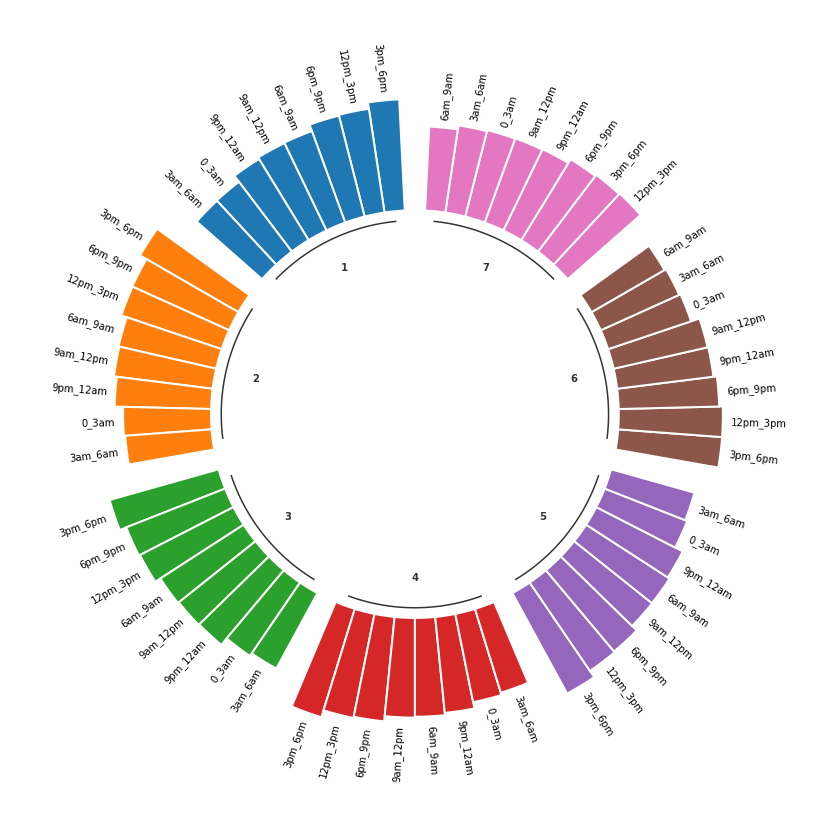

In [25]:
ANGLES = np.linspace(0, 2 * np.pi, len(train_process3_sorted), endpoint=False)
VALUES = train_process3_sorted['congestion'].values
LABELS = train_process3_sorted["hour_group"].values

# Determine the width of each bar. 
# The circumference is '2 * pi', so we divide that total width over the number of bars.
WIDTH = 2 * np.pi / len(VALUES)

# Determines where to place the first bar. 
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2



# Grab the group values
GROUP = train_process3_sorted["weekday"].values

# Add three empty bars to the end of each group
PAD = 1
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

# Obtaining the right indexes is now a little more complicated
offset = 0
IDXS = []
GROUPS_SIZE = [8, 8, 8, 8, 8, 8, 8]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

# Same layout as above
fig, ax = plt.subplots(figsize=(30, 15), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Use different colors for each group!
GROUPS_SIZE = [8, 8, 8, 8, 8, 8, 8]
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# And finally add the bars. 
# Note again the `ANGLES[IDXS]` to drop some angles that leave the space between bars.
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

offset = 0 
for group, size in zip(['1', '2', '3', '4', '5', '6', '7'], GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -20, group, color="#333333", fontsize=10, 
        fontweight="bold", ha="center", va="center"
    )
    
    offset += size + PAD


## wordcloud of the title

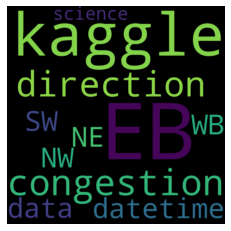

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a list of word
text=("kaggle congestion direction datetime SW NE NW EB WB EB data science")

# Create the wordcloud object
wordcloud = WordCloud(width=2000, height=2000, margin=2).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.show()